In [4]:
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
# import regionmask
from fiona.crs import from_epsg 
from shapely.geometry import Point, Polygon
import h5py as h5
from glob import glob
import json
import dask as da
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rasterio.warp import reproject, Resampling

import warnings
warnings.filterwarnings("ignore")

In [5]:
def gen_extent_from_neon_h5(fi, nid='CPER'):
    
    ds = h5.File(fi, 'r')
    map_info = str(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()])
    epsg = int(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()])
    data_shape = ds['CPER']['Reflectance']['Reflectance_Data'].shape
    
    # produce the affine transform components
    parts = [p.strip() for p in map_info.split(',')]
    aff = [float(p) for p in parts[1:7]]
    
    px, py, ul_x, ul_y = aff[:4]
    py = -py
    
    num_rows, num_cols, num_bands = data_shape
    
    # produce the points for the extent polygon
    ul = Point(ul_x, ul_y)
    ur = Point((ul_x +  num_cols*px), ul_y)
    ll = Point(ul_x, (ul_y + num_rows*py))
    lr = Point((ul_x + num_cols*px), (ul_y + num_rows*py))

    extent_poly = Polygon((ul, ur, lr, ll, ul))
    
    return extent_poly, epsg

# make function for reading h5 tiles
def read_h5_file(fi, nid='CPER'):
    # Read H5 file
    f = h5.File(fi, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()]
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()]
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'][()]

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    arr /= float(f[nid]['Reflectance']['Reflectance_Data'].attrs['Scale_Factor'])
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    # add in CRS assignemnt!!!!!!!!!!!!
    xr_cube_ma = xr_cube_ma.rio.write_crs(int(crs_epsg))
    
    return xr_cube_ma

def resample_h5_spectral(neon_file, weights_file):
    
    nis_ds = read_h5_file(neon_file)
    
    
    with open(weights_file, 'r') as fb:
        weights = json.load(fb)
    
    sample_bands = []
    for k in weights.keys():
        b_weights, b_ids = weights[k]
        sample_band = (nis_ds.isel(bands=b_ids)*np.array(b_weights)).sum(axis=-1)/ np.array(b_weights).sum()
        sample_bands.append(sample_band)
            
    
    sat_ds = xr.concat(sample_bands, dim=list(weights.keys())).rename({'concat_dim':'sat_band'}) # 'sat_band' will be new at dim=0
    
    return sat_ds

def check_valid_pixel_overlap(neon_file, geometry, weights_file):
    
    nis_ds = resample_h5_spectral(neon_file, weights_file)
    #print(nis_ds.spatial_ref)
    
    try:
        sample_clip = nis_ds.rio.clip([geometry])
        sample_im_clip = sample_clip.sel(sat_band='L8_Coastal')
        
        # count pixels vs total
        total_pixels = sample_im_clip.size
        gt0 = (sample_im_clip > 0.0).sum()
        valid_frac = gt0.values/total_pixels
        
        print(f'valid fraction: {valid_frac}')
        if valid_frac > 0.99:
            return valid_frac
        else:
            print('valid pixels are not above 99% of AOI, returning False')
            return valid_frac
    except Exception as e:
        
        print(e)
        print('not in bounds...')
        return 0.0

In [6]:
#geodataframe for file extents
h5_files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline/*.h5')
polys = [gen_extent_from_neon_h5(fi)[0] for fi in h5_files]
desc = [os.path.basename(fi).split('.')[0] for fi in h5_files]
epsg = gen_extent_from_neon_h5(h5_files[0])[1]

fl_gdf = gpd.GeoDataFrame({'geometry': polys, 'filename':desc}, crs=from_epsg(epsg))

<AxesSubplot:>

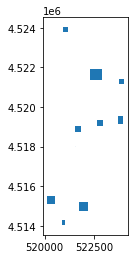

In [7]:
# load AOIS
aois = './aois/cper_aois.shp'
aoi_gdf = gpd.read_file(aois) # replace with shapefile or other
aoi_gdf['area_aoi'] = [g.area for g in aoi_gdf.geometry] # column for area
aoi_gdf.rename(columns={'desc_': 'desc'}, inplace=True)
aoi_gdf.plot()

In [8]:
# calculate the areas of overlap of AOI geometries within each flightline
aoi_overlap = gpd.overlay(fl_gdf, aoi_gdf, how='intersection')
aoi_overlap['area_ovr'] = aoi_overlap.geometry.area

# only save the ones that have full overlap
aoi_overlap = aoi_overlap.loc[aoi_overlap.area_ovr == aoi_overlap.area_aoi]
# aoi_overlap.area_ovr == aoi_overlap.area_aoi

In [9]:
# find the overlapping flightline with each ao
l8_weights_file = './spectral_response/NIS_weights_L8.json'

overlap_series = []
for geom, desc in zip(aoi_gdf.geometry, aoi_gdf.desc):
    
    print(desc)
    #nfi = os.path.join('../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline', row[1]['filename'] + '.h5')
    overlaps = []
    for nfi in h5_files:
        
        vfac = check_valid_pixel_overlap(nfi, geom, l8_weights_file)
        overlaps.append(vfac)
        
    overlap_series.append(overlaps)

    
# aoi_fl_df = gpd.GeoDataFrame(series, crs=from_epsg(epsg))
# aoi_fl_df.reset_index()

tarp_outline_1
No data found in bounds. Data variable: truediv-eb0a4d9cf7187038c89e1c765b3e669f
not in bounds...
No data found in bounds. Data variable: truediv-1ed2fef22d70ab116d8229f8ceb72266
not in bounds...
No data found in bounds. Data variable: truediv-df7292d178b8e7e277c55601131c5a20
not in bounds...
No data found in bounds. Data variable: truediv-db474191de1773997ba48e8ed96d3e75
not in bounds...
No data found in bounds. Data variable: truediv-b31f4fc97c9c09cd850a009bf386a129
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 1.0
valid fraction: 1.0
No data found in bounds. Data variable: truediv-1ae3389e6792acf084e6ea617376d652
not in bounds...
No data found in bounds. Data variable: truediv-0216fdbe0844f5fb319732cf6185c73e
not in bounds...
No data found in bounds. Data variable: truediv-81b29dec2766eb1918d5b9f6f35c6f00
not in bounds...
No data found in bounds. Data variable: truediv-43fed43af725faa11eb289f987113522
not i

No data found in bounds. Data variable: truediv-b6e819e9c8d69c5630b2eefa450dbd43
not in bounds...
No data found in bounds. Data variable: truediv-948843426360a99fc6548de8672e25b9
not in bounds...
No data found in bounds. Data variable: truediv-c5bbeba6b3e09037075ac3e40a03a2bf
not in bounds...
No data found in bounds. Data variable: truediv-3f5f6fd8eb487791e7610cde95db1d26
not in bounds...
No data found in bounds. Data variable: truediv-137473b2fdd4941f20f0d09e8ee94cfe
not in bounds...
No data found in bounds. Data variable: truediv-f1d2f76f5cc4c854bf8717edb6a6b6e6
not in bounds...
No data found in bounds. Data variable: truediv-c05fd16513110932171a574c3c20b24e
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.49103975761158736
valid pixels are not above 99% of AOI, returning False
valid fraction: 1.0
valid fraction: 0.32060017602134966
valid pixels are not above 99% of AOI, returning False
No data found in bounds. Data variabl

In [10]:
ov_thresh = 0.99

overlap_arr = np.array(overlap_series)
overlap_arr.max(axis=1)
list(zip(np.where(overlap_arr > ov_thresh)))

[(array([0, 0, 0, 1, 1, 1, 3, 4, 6, 7, 8, 9], dtype=int64),),
 (array([ 6,  7, 14,  6,  7, 14,  6,  3, 10,  8,  0,  0], dtype=int64),)]

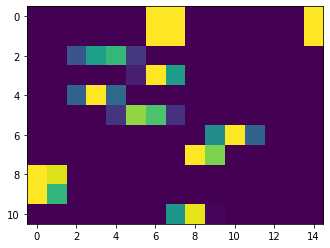

In [11]:
plt.imshow(overlap_arr)

In [12]:
rows, cols = np.where(overlap_arr > ov_thresh)
for i in range(rows.shape[0]):
    print(overlap_arr[rows[i], cols[i]])

1.0
1.0
1.0
1.0
1.0
1.0
0.9995164835164835
1.0
1.0
1.0
1.0
1.0


construct filename and geometry index pairs

In [13]:
# do this smartly
ov_idx = np.where(overlap_arr > ov_thresh)
_test = []
_temp_row, _temp_row_idx = [], []
for ix, a in enumerate(ov_idx[0]):
    if a in _temp_row:
        continue
    _temp_row.append(a)
    _temp_row_idx.append(ix)
    
for i,ix in enumerate(_temp_row_idx):
    _test.append((_temp_row[i], ov_idx[1][ix]))

# assign filename smartly
aoi_gdf['filename'] = None
for geomidx, fileidx in _test:
    aoi_gdf.at[geomidx,'filename'] = h5_files[fileidx]
    
       
            


In [14]:
aoi_gdf

,Shape_Leng,Shape_Area,desc,geometry,area_aoi,filename
0,56.563405,175.029482,tarp_outline_1,"POLYGON ((521558.002 4518008.657, 521558.170 4...",175.029482,../../NEON_spectrometer-orthorectified-surface...
1,54.479200,155.715737,tarp_outline_2,"POLYGON ((521576.763 4518020.205, 521576.763 4...",155.715737,../../NEON_spectrometer-orthorectified-surface...
2,2270.871600,322228.810508,riverbed_1,"POLYGON ((522306.667 4521898.897, 522883.033 4...",322228.810508,None
3,1348.775800,113548.628545,pond_1,"POLYGON ((521512.615 4519050.678, 521862.102 4...",113548.628545,../../NEON_spectrometer-orthorectified-surface...
4,1271.502000,100967.725783,rectangular_patch_1,"POLYGON ((522644.241 4519348.882, 522953.335 4...",100967.725783,../../NEON_spectrometer-orthorectified-surface...
5,1781.880200,197722.398591,pond_2,"POLYGON ((521750.166 4515215.188, 522168.782 4...",197722.398591,None
6,1611.686000,162327.746536,riverbed_2,"POLYGON ((520522.022 4515506.978, 520522.022 4...",162327.746536,../../NEON_spectrometer-orthorectified-surface...
7,749.269200,32507.902982,trees_1,"POLYGON ((520903.832 4514283.340, 521040.357 4...",32507.902982,../../NEON_spectrometer-orthorectified-surface...
8,1320.613200,101452.632694,veg_1,"POLYGON ((523719.494 4519531.704, 523962.764 4...",101452.632694,../../NEON_spectrometer-orthorectified-surface...
9,1059.018000,70005.110891,builtup_1,"POLYGON ((523777.942 4521429.533, 524033.218 4...",70005.110891,../../NEON_spectrometer-orthorectified-surface...


In [16]:
# try the resample_match technique for landsat
landsat_file = '../../OutputsL7/LS7_20200912_lat40lon10589_r32p34_msk_vmsk_mclds_topshad_rad_srefdem_stdsref.tif'
landsat_ds = rxr.open_rasterio(landsat_file)
l7_weights_file = './spectral_response/NIS_weights_L7.json'

## loop over the geometries and do the groupby method to produce STD and MEAN per satellite pixel

In [19]:
# lists to store results
res_L7_means, res_L7_stds =  [],[]
L7_arrs = []

# open the satellite image files
landsat_ds = rxr.open_rasterio(landsat_file)
for desc, geom, fi in aoi_gdf.dropna()[['desc', 'geometry', 'filename']].values:
    
    print(desc)
    
    # spectral resample to each satellite
    neon_ds_L7 = resample_h5_spectral(fi, l7_weights_file)
    
    # clip to current AOI
    neon_ds_L7 = neon_ds_L7.rio.clip([geom], all_touched=True, from_disk=True)
    
    # clip landsat and sentinel datasets, add to list
    L7_arrs.append(landsat_ds.rio.clip([geom], all_touched=True, from_disk=True))
    
    # group by for mean
    target_res = 30
    reduced_L7_mean = (
        neon_ds_L7
        .groupby(((neon_ds_L7.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_L7.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))
    
    # group by for STD
    target_res = 30
    reduced_L7_std = (
        neon_ds_L7
        .groupby(((neon_ds_L7.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_L7.y//target_res) + 0.5) * target_res)
        .std(dim='y'))

    
    # append to lists
    res_L7_means.append(reduced_L7_mean)
    res_L7_stds.append(reduced_L7_std)


tarp_outline_1
tarp_outline_2
pond_1
rectangular_patch_1
riverbed_2
trees_1
veg_1
builtup_1


tarp_outline_1
array is too small for anything, continuing...
tarp_outline_2
array is too small for anything, continuing...
pond_1


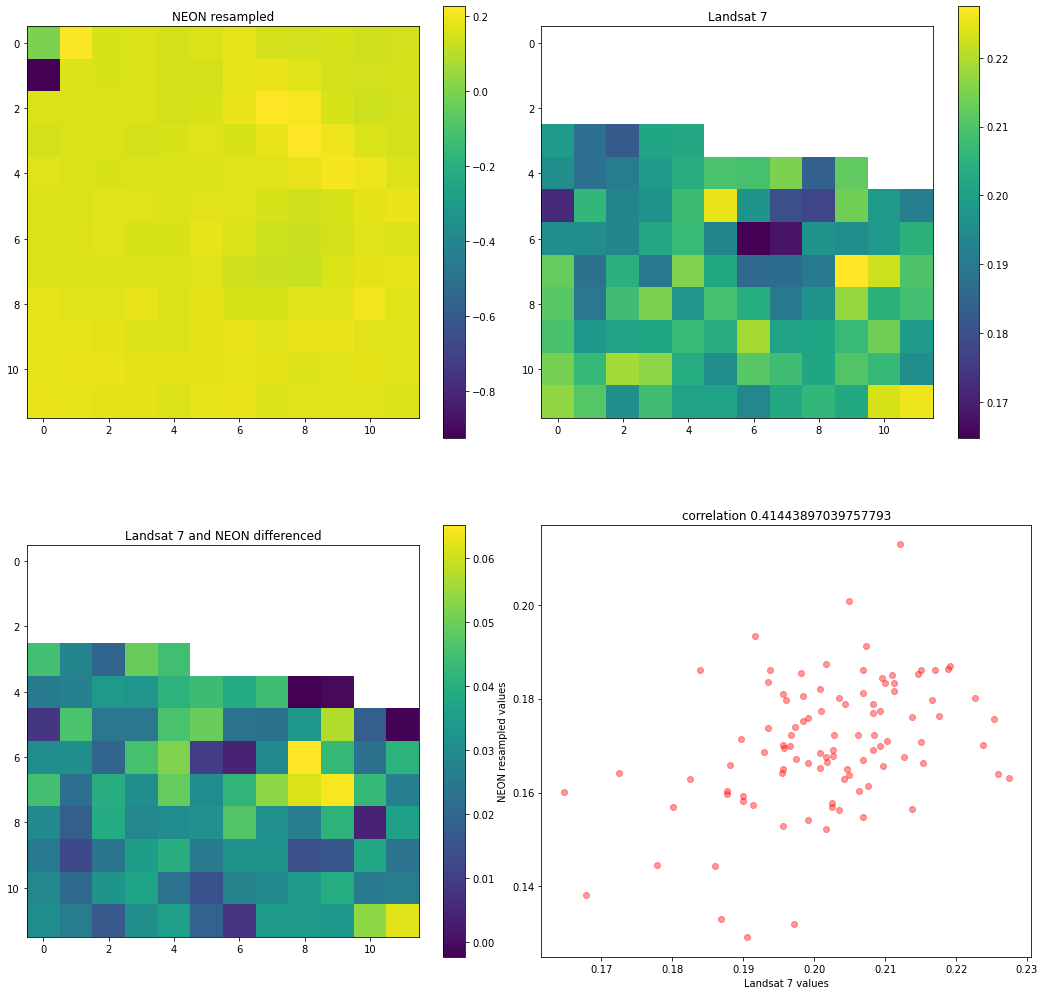

rectangular_patch_1


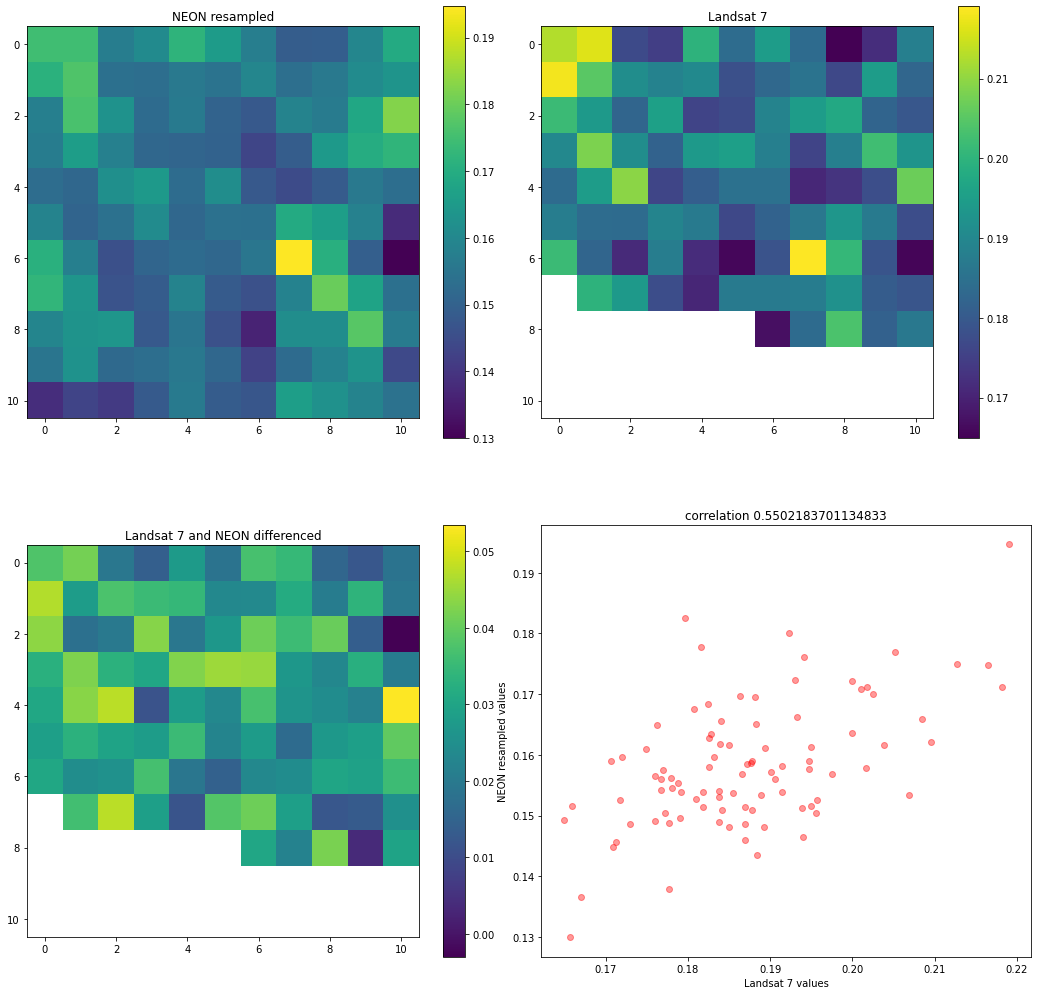

riverbed_2


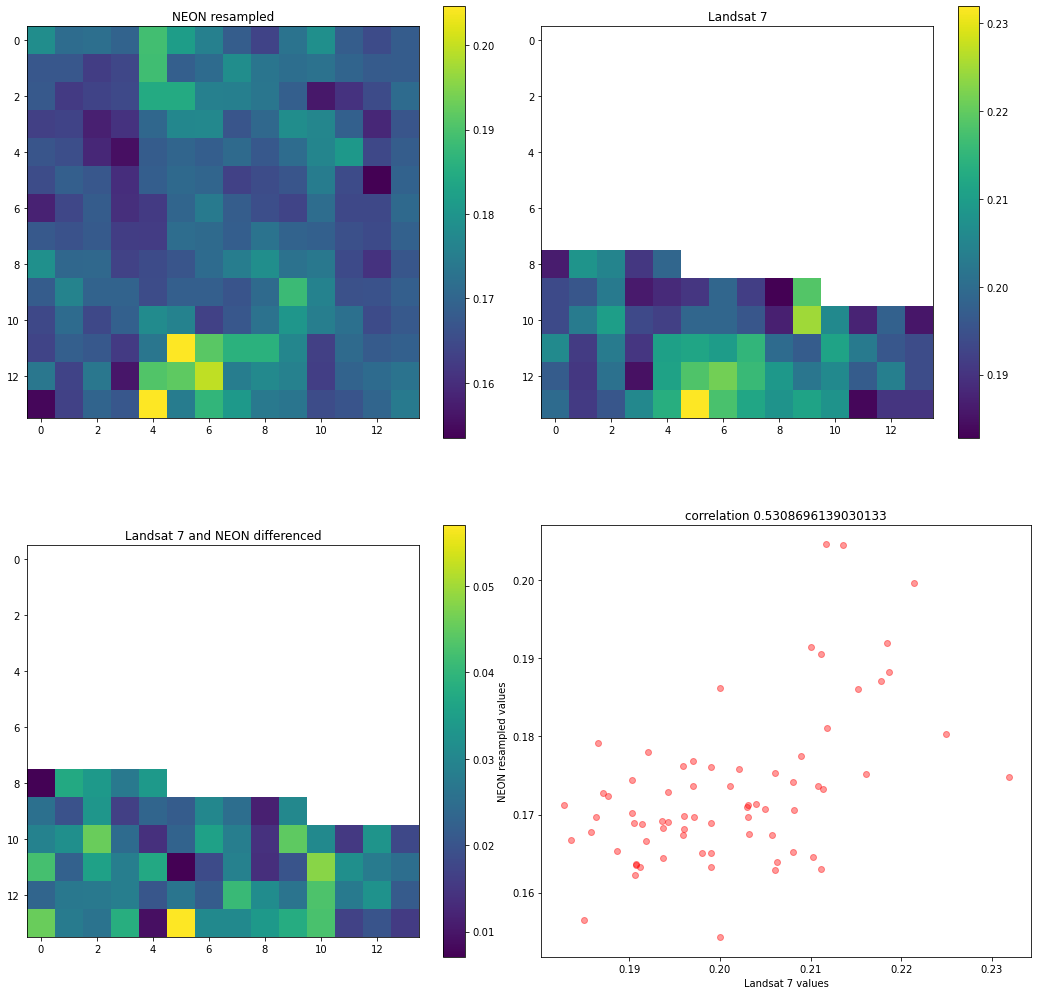

trees_1


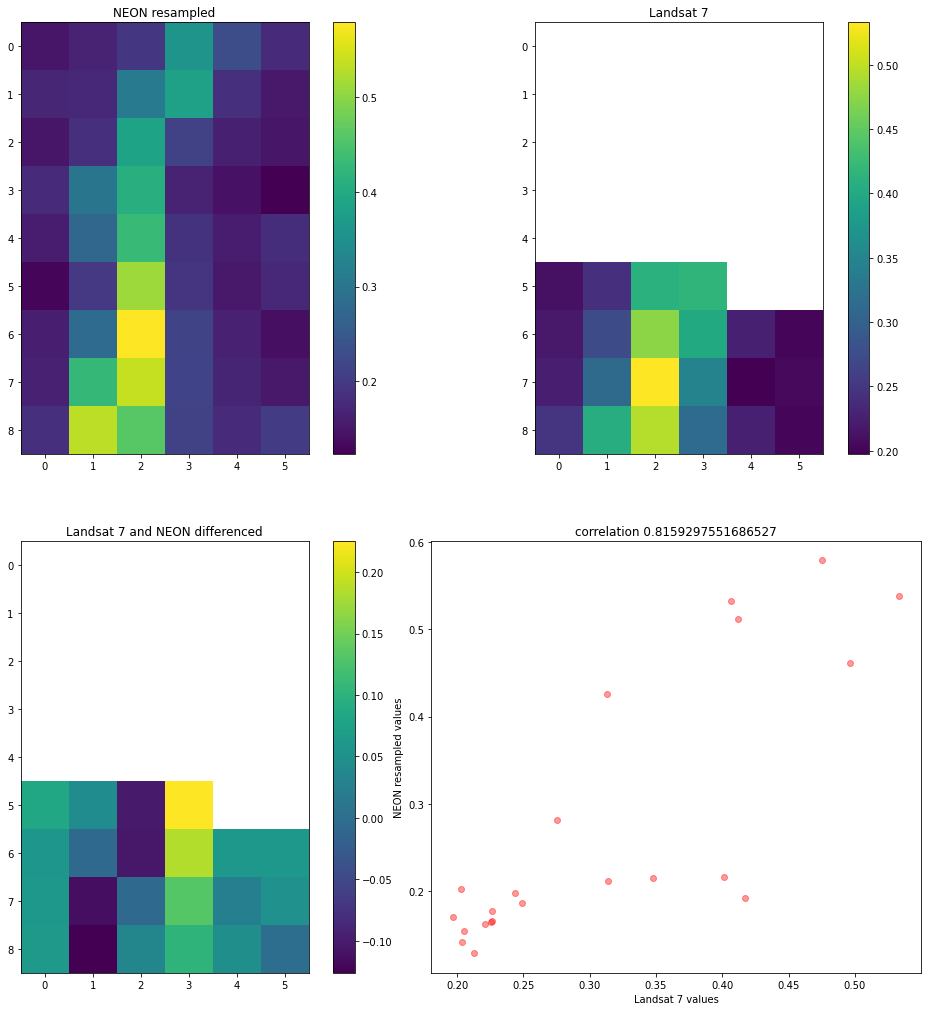

veg_1


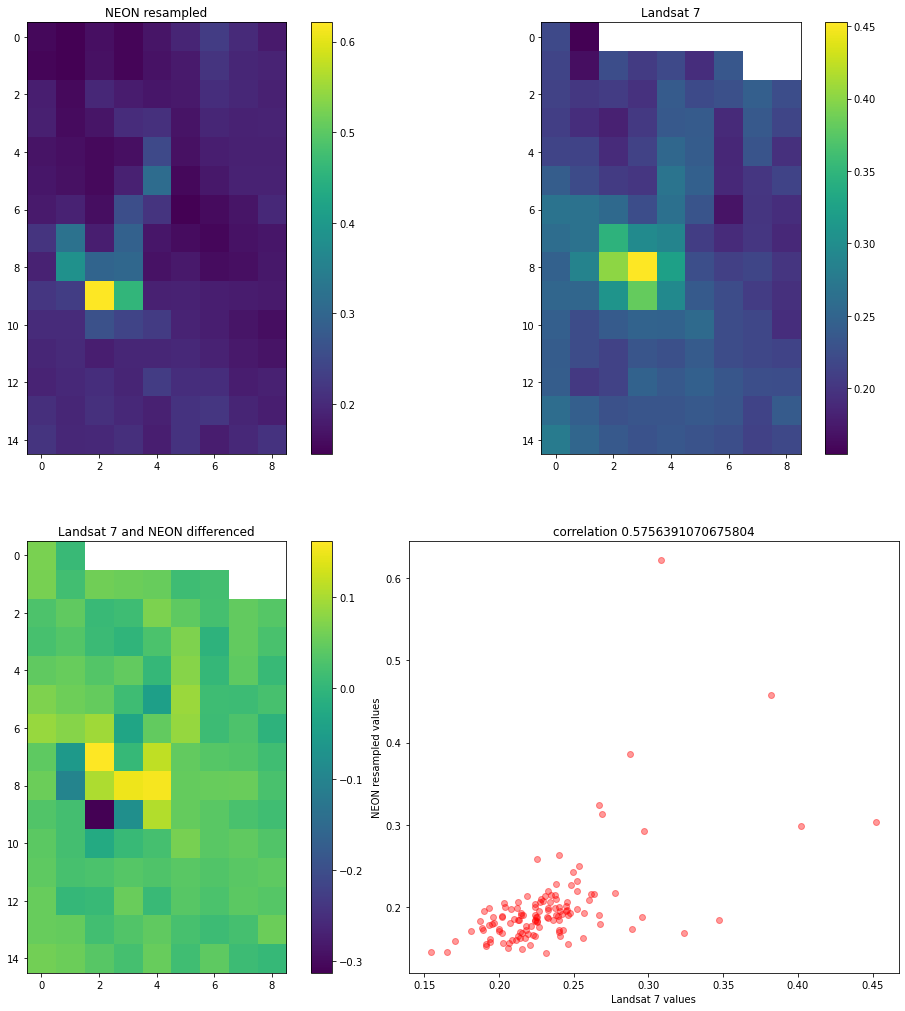

builtup_1


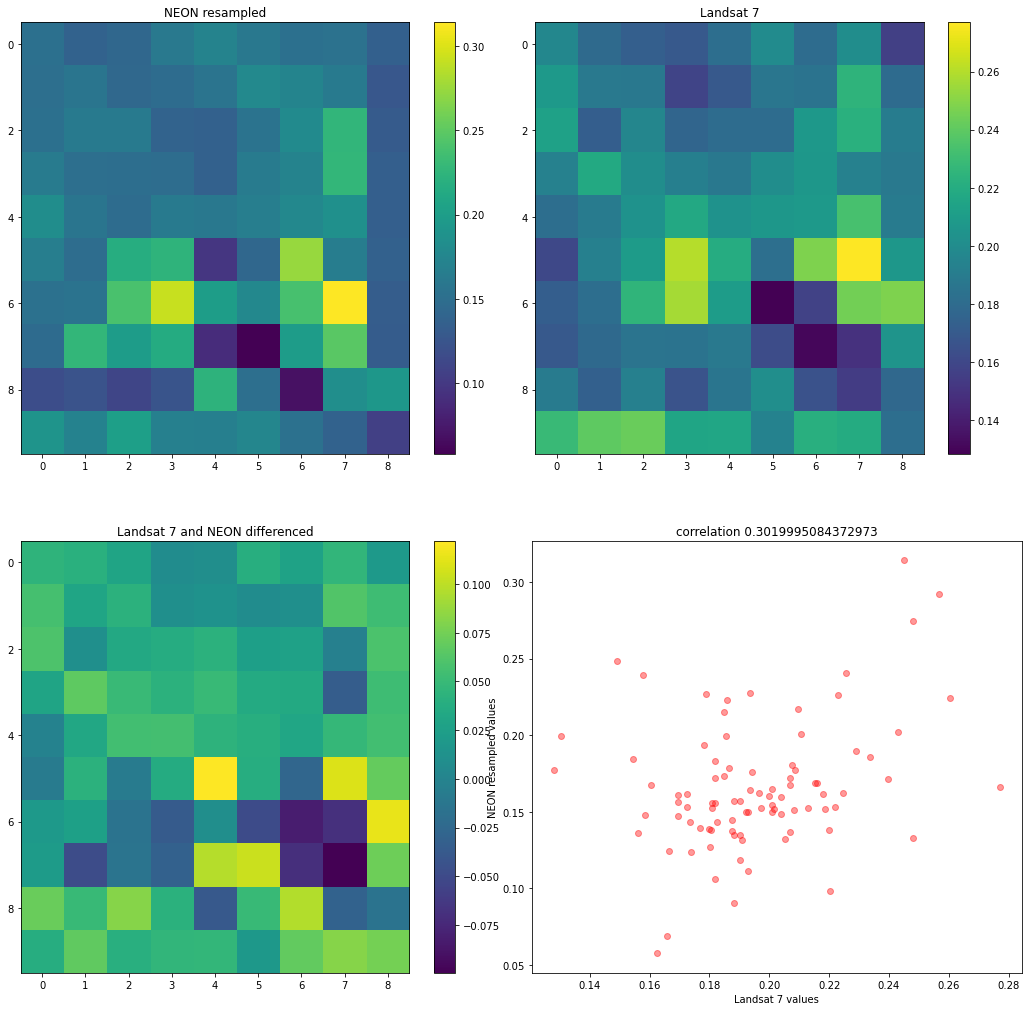

In [20]:
# plot Landsat 7 ndvi for AOIs
for desc, neon_L7, og_L7 in zip(aoi_gdf.dropna().desc.values, res_L7_means, L7_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_L7.sel(sat_band='L7_NIR') - neon_L7.sel(sat_band='L7_Red')
    neon_den = neon_L7.sel(sat_band='L7_NIR') + neon_L7.sel(sat_band='L7_Red')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    sat_num = og_L7.sel(band=4) - og_L7.sel(band=3)
    sat_den = og_L7.sel(band=4) + og_L7.sel(band=3)
    sat_ndvi = (sat_num.astype('float')/10000) / (sat_den.astype('float')/10000)
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
    neon_vals[neon_vals>1] = 1
    neon_vals[neon_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals)
    fig.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title('NEON resampled')
    
    im = ax[0,1].imshow(sat_vals)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title('Landsat 7')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title('Landsat 7 and NEON differenced')
    
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Landsat 7 values')
    ax[1,1].set_ylabel('NEON resampled values')
    ax[1,1].set_title(f'correlation {corr}')
    plt.show()